# Introduction

This notebook implements the ResNet model (https://arxiv.org/abs/1512.03385) in PyTorch.

Inspired by the torchvision implementation: https://github.com/pytorch/vision.

Trained on the CIFAR-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html.

# ResNet Architecture

![resnet](https://miro.medium.com/v2/resize:fit:512/1*kBlZtheCjJiA3F1e0IurCw.png)

In [ ]:
import torch
import torch.nn as nn

When dimensions increase (dotted line shortcuts), I use option (B) mentioned in the paper, using projection shortuct to match dimensions using 1x1 convolutions:

In [ ]:
class DownSample(nn.Module):
  def __init__(self, input_channels, output_channels, stride, kernel_size=1):
    super(DownSample, self).__init__()

    self.conv = nn.Conv2d(input_channels, output_channels,
                          kernel_size=kernel_size, stride=stride, bias=False)
    self.bn = nn.BatchNorm2d(output_channels)

  def forward(self, x):
    x = self.bn(self.conv(x))
    return x

![blocks](https://i.stack.imgur.com/kbiIG.png)

### Basic Block

In [ ]:
class ResNetBlock(nn.Module):
  # For a basic block, the feature map input and output size stays the same.
  expansion_factor = 1

  def __init__(self, input_channels, output_channels, stride=1):
    super(ResNetBlock, self).__init__()

    self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3,
                           stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(output_channels)

    self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3,
                           stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(output_channels)

    self.relu = nn.ReLU(inplace=True)

    self.down_sample = None
    # Apply down sample when dimension increases (dotted line shortcut).
    if stride != 1 or input_channels != output_channels * self.expansion_factor:
      self.down_sample = DownSample(input_channels,
                                    output_channels * self.expansion_factor,
                                    stride)

  def forward(self, x):
    f = self.relu(self.bn1(self.conv1(x)))
    f = self.bn2(self.conv2(f))

    if self.down_sample is not None:
      x = self.down_sample(x)

    out = f + x
    return self.relu(out)

### Bottleneck Block

In [ ]:
class BottleneckBlock(nn.Module):
  # For the bottleneck block, the feature map size increases by a factor of 4.
  expansion_factor = 4

  def __init__(self, input_channels, output_channels, stride=1):
    super(BottleneckBlock, self).__init__()

    self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=1,
                           bias=False)
    self.bn1 = nn.BatchNorm2d(output_channels)

    self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3,
                           stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(output_channels)

    self.conv3 = nn.Conv2d(output_channels, output_channels * self.expansion_factor,
                           kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(output_channels * self.expansion_factor)

    self.relu = nn.ReLU(inplace=True)

    # Apply down sample when dimension increases (dotted line shortcut).
    self.down_sample = None
    if stride != 1 or input_channels != output_channels * self.expansion_factor:
      self.down_sample = DownSample(input_channels,
                                    output_channels * self.expansion_factor,
                                    stride)

  def forward(self, x):
    f = self.relu(self.bn1(self.conv1(x)))
    f = self.relu(self.bn2(self.conv2(f)))
    f = self.bn3(self.conv3(f))

    if self.down_sample is not None:
      x = self.down_sample(x)

    out = f + x
    return self.relu(out)

## ResNet Model

In [ ]:
class ResNet(nn.Module):
  def __init__(self, block, layer_sizes, num_classes=10, num_channels=3):
    super(ResNet, self).__init__()

    # Keeps track of input size of the current layer.
    self.curr_input_channels = 64

    # Original values for ImageNet dataset:  kernel_size=7, stride=2, padding=3
    self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1,
                           bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool3x3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block, 64, layer_sizes[0], stride=1)
    self.layer2 = self._make_layer(block, 128, layer_sizes[1], stride=2)
    self.layer3 = self._make_layer(block, 256, layer_sizes[2], stride=2)
    self.layer4 = self._make_layer(block, 512, layer_sizes[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * block.expansion_factor, num_classes)

  def _make_layer(self, block, input_channels, n_blocks, stride):
    layers = []

    # First block has stride set to input stride
    layers.append(block(self.curr_input_channels, input_channels, stride))
    self.curr_input_channels = input_channels * block.expansion_factor

    # Remaining blocks in layer set stride to 1
    for i in range(1, n_blocks):
      layers.append(block(self.curr_input_channels, input_channels, stride=1))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.maxpool3x3(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

In [ ]:
def resnet18(**kwargs):
  return ResNet(ResNetBlock, [2, 2, 2, 2], **kwargs)

def resnet34(**kwargs):
  return ResNet(ResNetBlock, [3, 4, 6, 3], **kwargs)

def resnet50(**kwargs):
  return ResNet(BottleneckBlock, [3, 4, 6, 3], **kwargs)

def resnet101(**kwargs):
  return ResNet(BottleneckBlock, [3, 4, 23, 3], **kwargs)

def resnet152(**kwargs):
  return ResNet(BottleneckBlock, [3, 8, 36, 3], **kwargs)

# Data

In [ ]:
import torchvision
import torchvision.transforms as transforms

From paper, data augmentation includes random horizontal flip and 32x32 crop randomly sampled with 4 pixels padded on each side.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
BATCH_SIZE = 128

In [ ]:
NUM_WORKERS = 2

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                          transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=NUM_WORKERS)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                         transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=NUM_WORKERS)

100%|██████████| 170498071/170498071 [00:06<00:00, 27004262.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = [
  "airplane",
  "automobile",
  "bird",
  "cat",
  "deer",
  "dog",
  "frog",
  "horse",
  "ship",
  "truck"
]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def convert_image(image):
  return (image + 1) / 2

In [ ]:
samples = []

for i in range(36):
  samples.append(train_data.__getitem__(i))

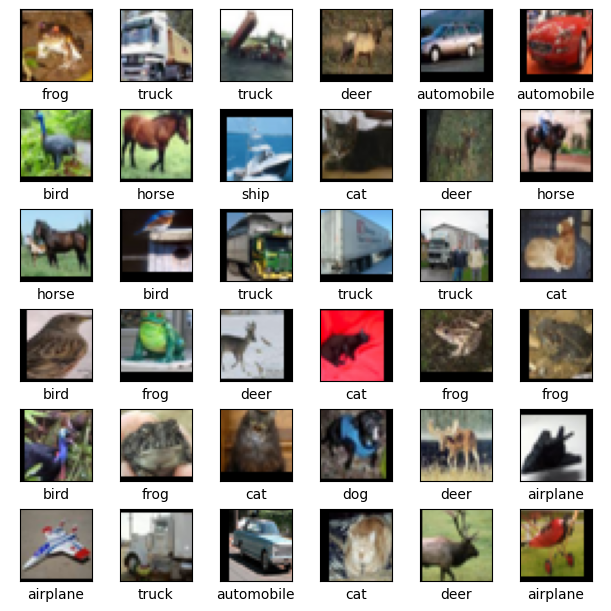

In [ ]:
fig, axs = plt.subplots(figsize=(6, 6), layout='constrained')
axs.set_axis_off()

for i in range(36):
  fig.add_subplot(6, 6, i+1)

  sample = samples[i]
  image = convert_image(sample[0])
  label = classes[sample[1]]

  plt.imshow(torch.permute(image, (1, 2, 0)))
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(label)

plt.show()

# Training

In [ ]:
#model = resnet34()
model = resnet50()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model.to(device)

In [ ]:
lr = 0.1
EPOCHS = 90

In [ ]:
def get_accuracy(y_pred, targets):
  predictions = torch.log_softmax(y_pred, dim=1).argmax(dim=1)
  accuracy = (predictions == targets).sum() / len(targets)
  return accuracy

From the paper use SGD optimizer. Learning rate starts from 0.1 and is divided by 10 when the error plateaus. Weight decay of 0.0001 and momentum of 0.9.

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                            weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1)

In [ ]:
def train(model):
  model.train()
  for epoch in range(EPOCHS):
    total_loss = 0
    total_acc = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = loss_function(outputs, labels)
      acc = get_accuracy(outputs, labels)

      total_loss += loss.item()
      total_acc += acc.item()

      loss.backward()
      optimizer.step()

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    scheduler.step(avg_loss)

    print(f"Epoch: {epoch + 1} Training loss: {avg_loss} | Training accuracy: {avg_acc}")

In [ ]:
train(model)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 Training loss: 2.679343585163126 | Training accuracy: 0.19984414960112412
Epoch: 2 Training loss: 1.844749454951957 | Training accuracy: 0.3127957160972878
Epoch: 3 Training loss: 1.6762319605063905 | Training accuracy: 0.3829124040920716
Epoch: 4 Training loss: 1.5606094641453774 | Training accuracy: 0.42877237853186817
Epoch: 5 Training loss: 1.4572127773938581 | Training accuracy: 0.4678388747107952
Epoch: 6 Training loss: 1.371548992593575 | Training accuracy: 0.5002197890025576
Epoch: 7 Training loss: 1.2789737248359738 | Training accuracy: 0.5376438618925832
Epoch: 8 Training loss: 1.1949454309690335 | Training accuracy: 0.5689697890635341
Epoch: 9 Training loss: 1.1249348621844026 | Training accuracy: 0.5977022059433296
Epoch: 10 Training loss: 1.0587128903859717 | Training accuracy: 0.623285645871516
Epoch: 11 Training loss: 0.9833857276860405 | Training accuracy: 0.6517503197540713
Epoch: 12 Training loss: 0.9349236907556538 | Training accuracy: 0.6695692135244989
Epo

# Evaluation

In [ ]:
def test(model):
  model.eval()
  total_loss = 0
  total_acc = 0

  for batch_idx, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    acc = get_accuracy(outputs, labels)

    loss = loss_function(outputs, labels)
    total_loss += loss.item()
    total_acc += acc.item()

  avg_loss = total_loss / len(test_loader)
  avg_acc = total_acc / len(test_loader)
  print(f"Test loss: {avg_loss} | Test accuracy: {avg_acc}")

In [ ]:
test(model)

Test loss: 0.467822325003298 | Test accuracy: 0.861748417721519


ResNet34:  
Test loss: 0.4407917279985887 | Test accuracy: 0.8779667721518988

ResNet50:  
Test loss: 0.467822325003298 | Test accuracy: 0.861748417721519

### Predictions

In [ ]:
def get_pred(image, model):
  prediction = model(image.to(device))
  pred_class = torch.log_softmax(prediction, dim=1).argmax(dim=1)
  return pred_class

In [ ]:
test_samples = []

for i in range(36):
  test_samples.append(test_data.__getitem__(i))

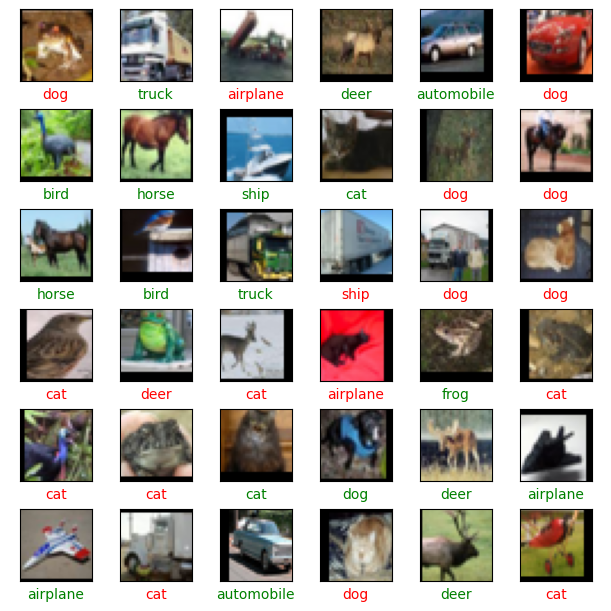

In [ ]:
fig, axs = plt.subplots(figsize=(6, 6), layout='constrained')
axs.set_axis_off()

for i in range(36):
  fig.add_subplot(6, 6, i+1)

  sample = samples[i]
  image = convert_image(sample[0])
  pred_class = get_pred(image[None,:,:,:], model)
  label = classes[pred_class]

  plt.imshow(torch.permute(image, (1, 2, 0)))
  plt.xticks([])
  plt.yticks([])

  color = 'green' if pred_class == sample[1] else 'red'
  plt.xlabel(label, color=color)

plt.show()